<a href="https://colab.research.google.com/github/theresiasns/MachineLearning/blob/main/Soil_prediction_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pathlib

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-03 07:46:58--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   228MB/s    in 0.4s    

2023-06-03 07:46:59 (228 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Set the path to the image dataset folder
dataset_path = '/content/drive/MyDrive/Tanah'



In [ ]:
# Define the class labels
class_labels = ['01-Aluvial', '02-Andosol', '03-Entisol', '04-Humus', '05-Inceptisol', '06-Laterit', '07-Kapur', '08-Pasir']
num_classes = len(class_labels)


# Data preprocessing
data = []
labels = []
for i, class_label in enumerate(class_labels):
    class_folder_path = os.path.join(dataset_path, class_label)
    for image_name in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, image_name)
        image = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        image_array = keras.preprocessing.image.img_to_array(image)
        data.append(image_array)
        labels.append(i)



In [ ]:
# Convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape= (224,224,3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(8, activation='softmax')(x)


#Append the dense network to the base model
model = Model( pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Normalize the image data
data = data / 255.0

# Split the dataset into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
train_datagen.fit(train_data)

In [ ]:
history = model.fit(train_datagen.flow(train_data, train_labels, batch_size=10),
                    steps_per_epoch=len(train_data) // 10,
                    epochs=50,
                    validation_data=(val_data, val_labels))

Epoch 1/50
70/70 [==============================] - 105s 1s/step - loss: 3.6604 - accuracy: 0.3170 - val_loss: 1.5453 - val_accuracy: 0.4489
Epoch 2/50
70/70 [==============================] - 114s 2s/step - loss: 1.3404 - accuracy: 0.5288 - val_loss: 0.8480 - val_accuracy: 0.7159
Epoch 3/50
70/70 [==============================] - 104s 1s/step - loss: 1.0375 - accuracy: 0.6412 - val_loss: 0.6631 - val_accuracy: 0.7898
Epoch 4/50
70/70 [==============================] - 95s 1s/step - loss: 0.7372 - accuracy: 0.7378 - val_loss: 0.5493 - val_accuracy: 0.8125
Epoch 5/50
70/70 [==============================] - 103s 1s/step - loss: 0.5368 - accuracy: 0.8228 - val_loss: 0.4180 - val_accuracy: 0.8352
Epoch 6/50
70/70 [==============================] - 94s 1s/step - loss: 0.5804 - accuracy: 0.8098 - val_loss: 0.3763 - val_accuracy: 0.8807
Epoch 7/50
70/70 [==============================] - 110s 2s/step - loss: 0.5843 - accuracy: 0.8141 - val_loss: 0.4523 - val_accuracy: 0.8466
Epoch 8/50
70/7

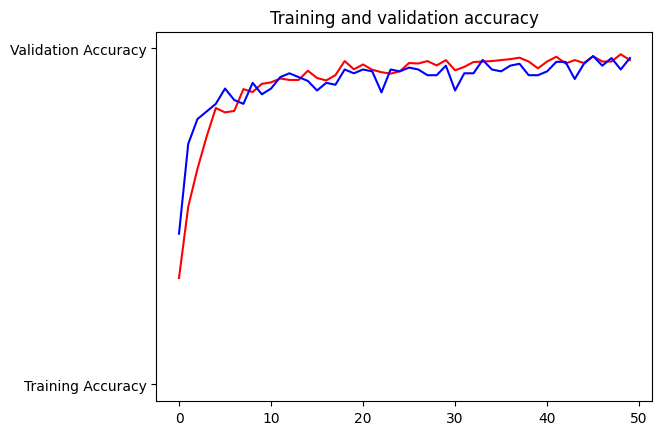

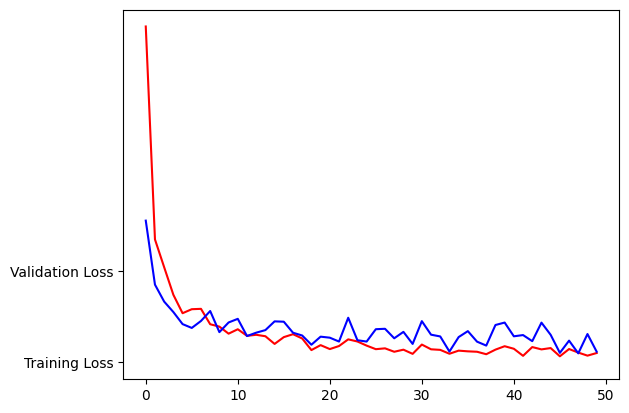

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
 # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

images = os.listdir("/tmp/images")

print(images)

for i in images:
  print()
 # predicting images
  path = '/tmp/images/' + i
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  pred = np.argmax(classes, axis=-1)
  predicted_label = class_labels[pred[0]]

  print("Predicted Label:", predicted_label)
  print(path)
  #print("Prediction Scores:", classes)


['fresh-2386786-1920_ver_1.jpg', 'shutterstock_389823613.jpg', 'soil-profile-Inceptisol-accumulation-humus-clay-minerals.jpg.webp', 'tanah-podsol.jpg', 'aluvial.jpg', 'image5.jpg', 'tanah-aluvial.jpg', '2.-Ciri-Tanah-Aluvial-Proses-Terbentuknya-Hingga-Manfaat-Untuk-Pertanian.jpg', 'glen-carrie-ib1jujyqob4-unsplash-easy-resizecom-1b6d1cd853484267ae86171b72dde9ea-203cacbc16e5ed7f1ba584dace0e1f12_600x400.jpg', 'istockphoto-1206172322-1024x1024.jpg', 'aluvial3.jpg.webp', 'aluvial2.jpg']

1/1 [==============================] - 0s 374ms/step
Predicted Label: 04-Humus
/tmp/images/fresh-2386786-1920_ver_1.jpg

1/1 [==============================] - 0s 102ms/step
Predicted Label: 05-Inceptisol
/tmp/images/shutterstock_389823613.jpg

1/1 [==============================] - 0s 104ms/step
Predicted Label: 03-Entisol
/tmp/images/soil-profile-Inceptisol-accumulation-humus-clay-minerals.jpg.webp

1/1 [==============================] - 0s 102ms/step
Predicted Label: 02-Andosol
/tmp/images/tanah-podsol.

In [ ]:
# Save model weights and architecture
model.save_weights('/content/drive/MyDrive/saved_models/model_weights.h5')
model.save('/content/drive/MyDrive/saved_models/model_saved.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load model architectur
loaded_model = load_model('/content/drive/MyDrive/saved_models/model_saved.h5')

# Load model weights
loaded_model.load_weights('/content/drive/MyDrive/saved_models/model_weights.h5')


In [ ]:
!pip install tensorflow_model_optimization
from tensorflow_model_optimization.sparsity import keras as sparsity

prune_low_magnitude = sparsity.prune_low_magnitude
pruned_model = prune_low_magnitude(model)
pruned_model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 56.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [ ]:
export = '/content/drive/MyDrive/saved_models/saved_model'
tf.saved_model.save(model, export)

In [ ]:
# Select mode of optimization
mode = "Storage"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_ops = 1000000
converter.experimental_new_converter = True
converter.experimental_new_converter_num_threads = 1
tflite_model = converter.convert();


In [ ]:
tflite_model_file = pathlib.Path('./Soil_Predict.tflite')
tflite_model_file.write_bytes(tflite_model)

131751704

In [ ]:
prediction = loaded_model.predict()

In [ ]:
 # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

images = os.listdir("/tmp/images")

print(images)

for i in images:
  print()
 # predicting images
  path = '/tmp/images/' + i
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = loaded_model.predict(images, batch_size=10)
  pred = np.argmax(classes, axis=-1)
  predicted_label = class_labels[pred[0]]

  print("Predicted Label:", predicted_label)
  print(path)
  #print("Prediction Scores:", classes)


FileNotFoundError: ignored